# Importing Libraries:

In [34]:

import numpy as np 
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
from sklearn.svm import SVC
import time
import pickle
import os
from sklearn.preprocessing import LabelEncoder
import seaborn as sn


#Added imports for CNN:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout

# Loading and Preprocessing Data:





**Defining Data Pre-Processing Funtions:**

In [11]:
#DEFINING PREPROCESSING FUNCTIONS:


def preprocess_spectrogram(df):#if the entire column is NaNs, we drop it, otherwise we replace the NaNs with the mean of the column
    #first we drop the columns with only NaNs
    df = df.dropna(axis=1, how='all')
    # Convert to numeric array
    matrix = df.to_numpy(dtype=float)            
    freqs = df.columns.to_numpy(dtype=float) 
    
    # Replace any NaNs with mean of the column without the Nans
    if np.isnan(matrix).any():
      col_means = np.nanmean(matrix, axis=0)
      inds = np.where(np.isnan(matrix))
      matrix[np.where(np.isnan(matrix))] = np.take(np.nanmean(matrix, axis=0), inds[1])

    # Sort by frequency (lowest → highest)
    #idx = np.argsort(freqs)
    #freqs = freqs[idx]#reorders freqs to give the frequencies in order
    #matrix_sorted = matrix[:, idx]     # reorders it 

    return matrix, freqs

def extract_envelopes(matrix, freqs, sigma_u=0.0005, sigma_l=0.0005):#based on paper we classify the hand gestures based on the envelopes of their micro doppler signature
    #Shape is (time, frequency)
    # Create a Boolean mask for positive frequencies
    N, K=matrix.shape #shape variables according to paper
    pos_mask = freqs >= 0#returns series of booleans
    neg_mask= freqs <0
    # Select columns where frequency is positive
    pos_half = matrix[:, pos_mask]
    neg_half = matrix[:, neg_mask] 
    f_neg=freqs[neg_mask] 
    f_pos=freqs[pos_mask] 
    
    # Eu and El
    EU = np.sum(pos_half**2, axis=1)   #sum from 0 to K/2 -1 of Spectogram squared for each time frame so axis 1
    EL = np.sum(neg_half**2, axis=1)   #sum from K/2 to K-1 of Spectogram squared
    TU = sigma_u * EU # we then scale the energy to define thresholds
    TL = sigma_l * EL
    #We use these thresholds to see which frequencies have a significant energy
    eU = []
    eL = []
    #freq where amplitude greater 
    for i in range(matrix.shape[0]):
        
        col_pos=pos_half[i,:]#we go through it for each time step
        col_neg=neg_half[i,:]

        #freq where amplitude greater than threshold
        above_thresh_pos=np.where(col_pos>=TU[i])[0]
        above_thresh_neg=np.where(np.abs(col_neg)>=TL[i])[0]

        if len(above_thresh_pos)>0:
            valid_freqs_pos=f_pos[above_thresh_pos]
            if valid_freqs_pos.size > 0:
                eU.append( np.max(valid_freqs_pos))# max values have the most influence
        if len(above_thresh_neg)>0:
            valid_freqs_neg=f_neg[above_thresh_neg]
            if valid_freqs_neg.size > 0:
                eL.append( np.min(valid_freqs_neg))
      
    return eU, eL

    
def build_feature_vector(eU, eL):
    return np.concatenate([eU, eL])

**Loading Data and Extracting Features:**

In [12]:
#Base path for where the files are located:
base_path='/Users/beno/Desktop/TU DELFT/ML for EE/WICOS'

# Check if the base path exists
if not os.path.exists(base_path):
    print(f"Error: The provided base path does not exist: {base_path}")
else:
    print(f"Base path found: {base_path}")
    
    
people = ['Person A', 'Person B', 'Person C', 'Person D', 'Person E', 'Person F']  
gestures = ['click', 'pinch', 'swipe', 'wave']

X = {}
y=[]


for person in people:
    for gesture in gestures:
        gesture_path = os.path.join(base_path, person, gesture)
        if os.path.exists(gesture_path):
            files = [f for f in os.listdir(gesture_path) if f.endswith('.csv')]
            dfs = []
            for f in files:
                df = pd.read_csv(os.path.join(gesture_path, f), dtype=np.float32)
                matrix, freqs = preprocess_spectrogram(df)
                pos_env, neg_env = extract_envelopes(matrix, freqs)
                features = build_feature_vector(pos_env, neg_env)
                dfs.append(features)
                y.append(gesture)
            X[f'{person}_{gesture}'] = dfs 
        else:
            print(f"Error: Data directories not found")

Base path found: /Users/beno/Desktop/TU DELFT/ML for EE/WICOS


In [17]:

len(X.keys())
#X['Person A_click']

24

In [29]:
#padded features
def pad_to_max_length(feature_list, pad_value=0.0):
    max_len = max(len(vec) for vec in feature_list)
    padded = []
    for vec in feature_list:
        vec = np.pad(vec, (0, max_len - len(vec)), mode='constant', constant_values=pad_value)
        padded.append(vec)
    return np.array(padded)
    
from scipy.signal import resample

def resample_to_fixed_length(data_list, target_len):
    return [resample(vec, target_len) for vec in data_list]

**Creating Databases of each gesture:**

In [27]:
#Create databases of each gesture and scale them:

def get_data(X, name):
    data=[] 
    for i in X.keys():
        if name in i:
            resampled = pad_to_max_length(X[i])
            data.append(np.array(resampled))
    return data

click_data = get_data(X, 'click')
pinch_data= get_data(X, 'pinch')
swipe_data = get_data(X, 'swipe')
wave_data = get_data(X, 'wave')


**Spectograms of gesture data:**

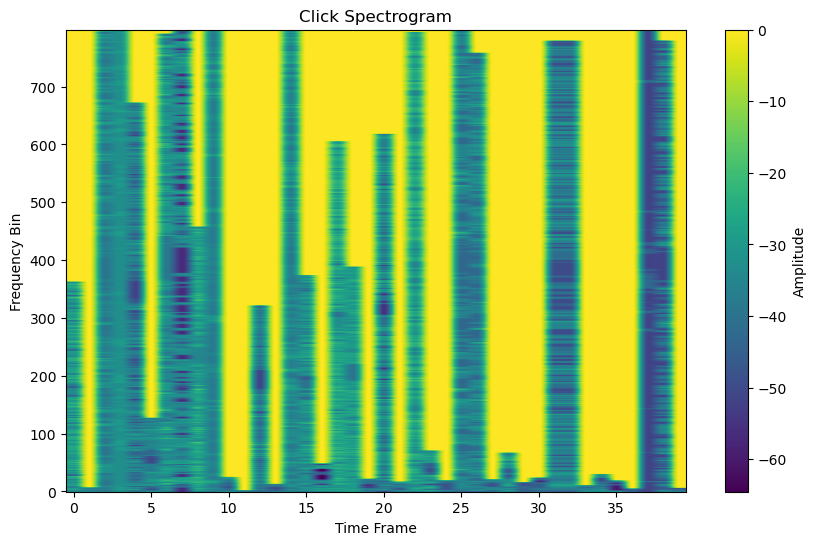

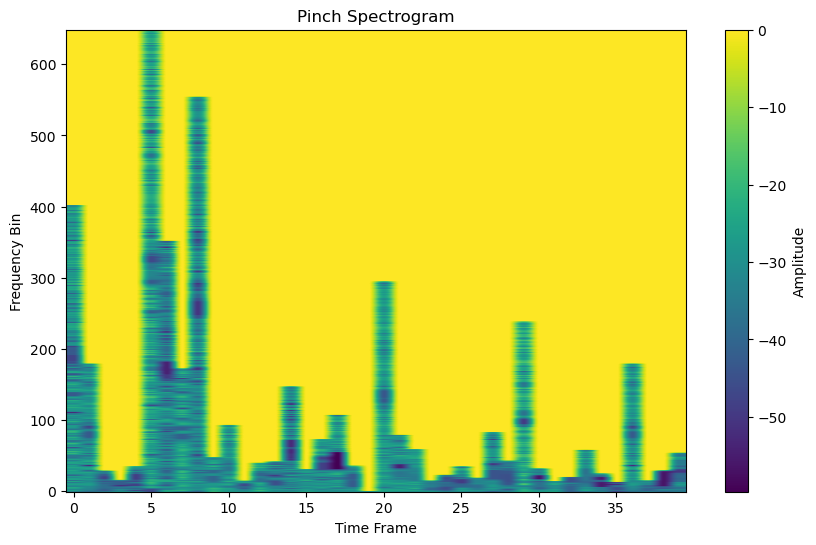

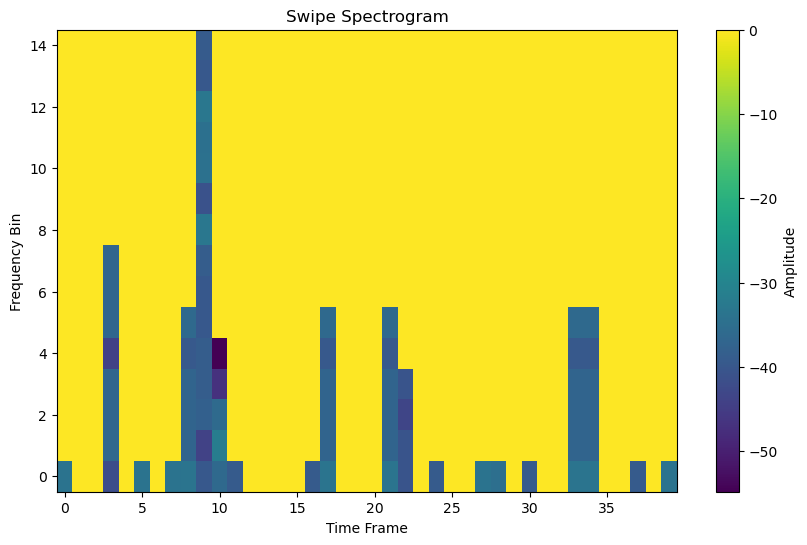

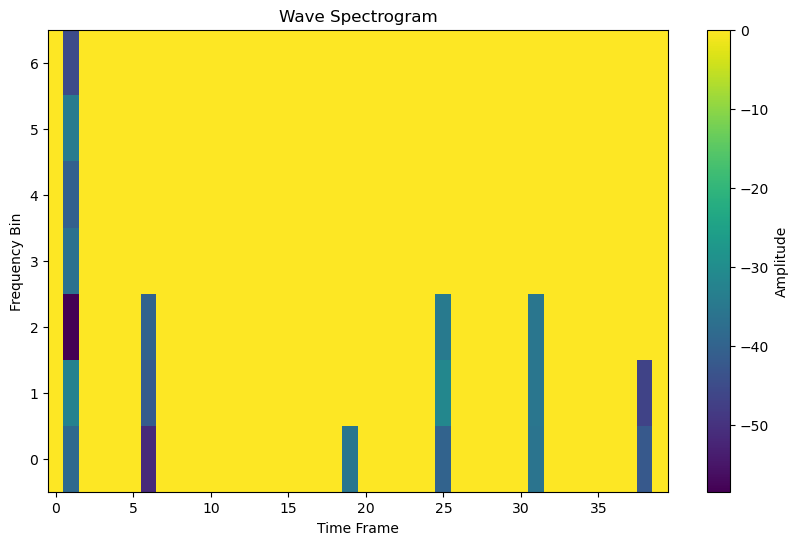

In [32]:
#Spectogram of Click:
plt.figure(figsize=(10, 6))
plt.imshow(click_data[0].T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.title('Click Spectrogram')
plt.show()

#Spectogram of Pinch:
plt.figure(figsize=(10, 6))
plt.imshow(pinch_data[0].T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.title('Pinch Spectrogram')
plt.show()

#Spectogram of Swipe:
plt.figure(figsize=(10, 6))
plt.imshow(swipe_data[0].T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.title('Swipe Spectrogram')
plt.show()

#Spectogram of Wave:
plt.figure(figsize=(10, 6))
plt.imshow(wave_data[0].T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.title('Wave Spectrogram')
plt.show()

In [22]:

scaler= StandardScaler()
encoder=LabelEncoder()
#encode the gestures in y to be able to train the models
y_encoded = encoder.fit_transform(y)
#padding

flat_X = [vec for sublist in X.values() for vec in sublist]
max_len = max(len(f) for f in flat_X)
X_padded = np.array([np.pad(f, (0, max_len - len(f)), 'constant') for f in flat_X])

X_scaled=scaler.fit_transform(X_padded)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y)






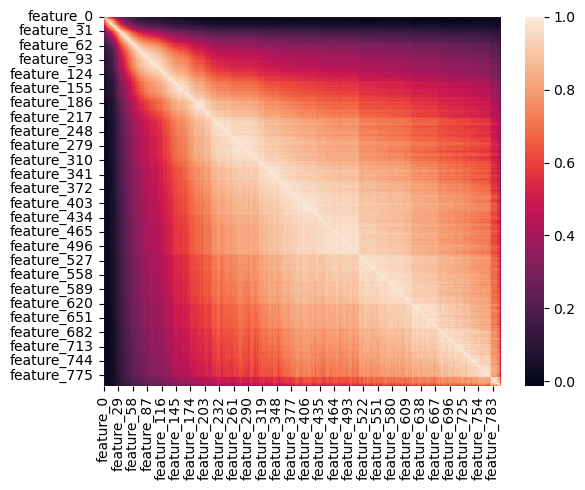

In [23]:
#Correlation matrix
df_features = pd.DataFrame(X_scaled)
df_features.columns = [f'feature_{i}' for i in range(df_features.shape[1])]

corrMatrix = df_features.corr()


#Heatmap
sn.heatmap(corrMatrix)
plt.show()

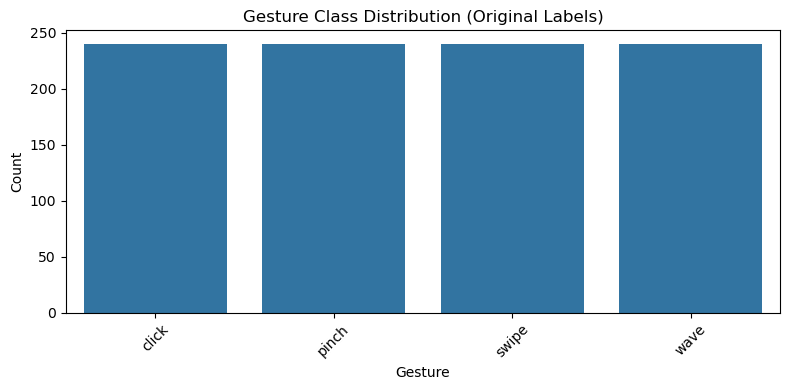

In [171]:
#Class distribution
plt.figure(figsize=(8, 4))
sn.countplot(x=y)
plt.title("Gesture Class Distribution (Original Labels)")
plt.xlabel("Gesture")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()

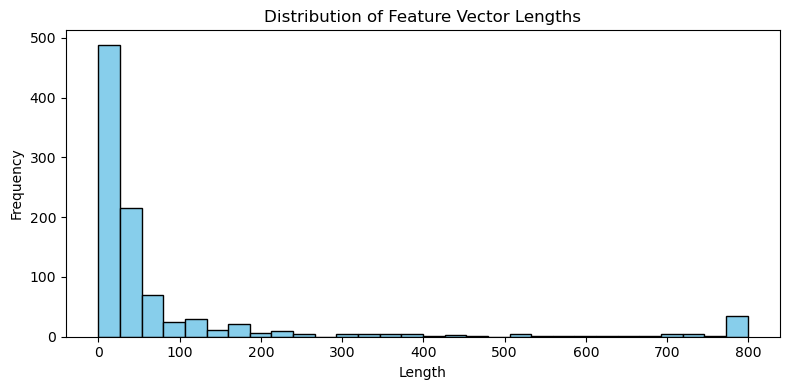

In [24]:
#feature lengths before padding
lengths = [len(f) for f in flat_X]
plt.figure(figsize=(8, 4))
plt.hist(lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Feature Vector Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.tight_layout()



# Classification Models:

**KNN:**

In [25]:
#Knn 
X_knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')#Knn model according to article
X_knn.fit(X_train, y_train)
y_pred = X_knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5208333333333334


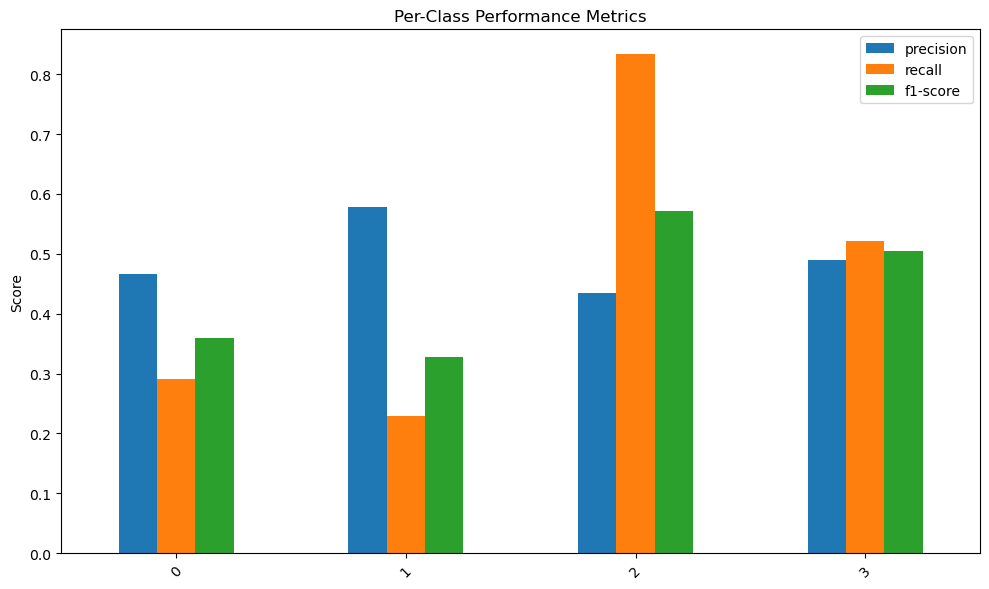

In [75]:
#model accuracy per gesture
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report.iloc[:-3][['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title("Per-Class Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()

In [18]:
# Transpose so columns become rows, then find unique rows
_, unique_indices = np.unique(X_scaled.T, axis=0, return_index=True)

# Total columns
total_cols = X_scaled.shape[1]

# Number of duplicate columns
num_duplicates = total_cols - len(unique_indices)
print("Duplicate columns:", num_duplicates)



Duplicate columns: 0


Constant columns: 0


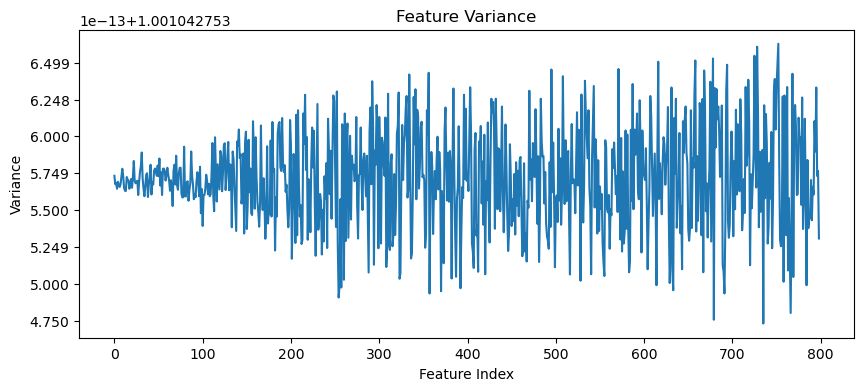

In [19]:
df_scaled = pd.DataFrame(X_scaled)
constant_cols = (df_scaled.nunique() == 1).sum()
print("Constant columns:", constant_cols)
plt.figure(figsize=(10, 4))
plt.plot(df_scaled.var())
plt.title("Feature Variance")
plt.xlabel("Feature Index")
plt.ylabel("Variance")
plt.show()

In [20]:
#SVM
X_SVM=SVC(kernel='rbf', C=1.0,  gamma ='scale' )
X_SVM.fit(X_train, y_train)
y_pred = X_SVM.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.5


In [21]:
#logistic Regression
X_lin_reg=LogisticRegression(max_iter=int(1e6))
X_lin_reg.fit(X_train, y_train)
y_pred = X_lin_reg.predict(X_test)
print("Accuracy:", accuracy_score( y_test, y_pred))

Accuracy: 0.4166666666666667


In [22]:
#Deep learning models :



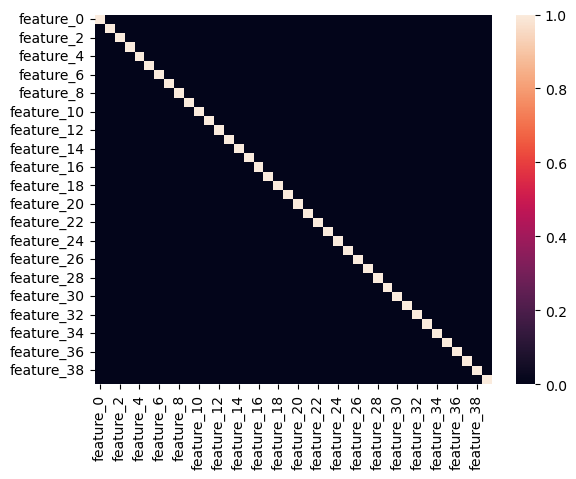

In [77]:
#PCA for features

from sklearn.decomposition import PCA

X_gestures={}

for k in gestures:
    data=[]
    for i in X.keys():
        if k in i:
            data.extend(X[i])
    X_gestures[f'{k}']=data


pca = PCA()
X_PCA={}
for i in X.keys():
        X_padded= pad_to_max_length(X[i])
        X_PCA[i]=pca.fit_transform(X_padded)
            


In [25]:
#Task 2
scaler= StandardScaler()
encoder=LabelEncoder()
#encode the gestures in y to be able to train the models
y_encoded = encoder.fit_transform(y)
#padding

flat_X = [vec for sublist in X_PCA.values() for vec in sublist]
max_len = max(len(f) for f in flat_X)
X_padded = np.array([np.pad(f, (0, max_len - len(f)), 'constant') for f in flat_X])

X_scaled=scaler.fit_transform(X_padded)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y)






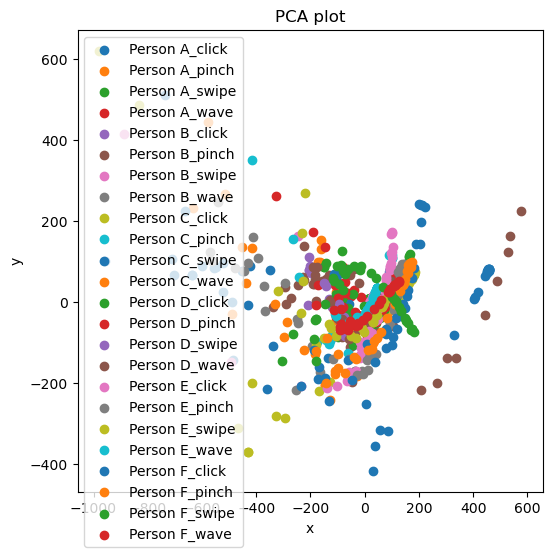

In [26]:
plt.figure(figsize=(6,6))
for label, data in X_PCA.items():
    plt.scatter(data[:, 0], data[:, 1], label=label)
plt.xlabel('x')
plt.ylabel('y')
plt.title('PCA plot')
plt.legend()
plt.show()

In [78]:
X_knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')#Knn model according to article
X_knn.fit(X_train, y_train)
y_pred = X_knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.46875


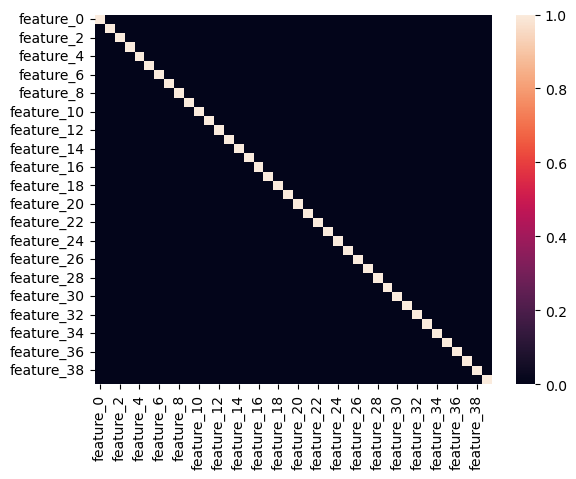

In [80]:
#Correlation matrix
df_features = pd.DataFrame(X_scaled)
df_features.columns = [f'feature_{i}' for i in range(df_features.shape[1])]

corrMatrix = df_features.corr()


#Heatmap
sn.heatmap(corrMatrix)
plt.show()

In [162]:
#test for different sigma parameters
sigma_list = [ 0.0005, 0.000475, 0.00045, 0.000425, 0.0004, 0.000375, 0.00035, 0.000325, 0.0003, 0.000275, 0.00025, 0.000225, 0.00020, 0.000175, 0.00015]
X_names=[0,1,2,3,4,5,6,7,8,9,10,11,12,13, 14]
for name in X_names:
    globals()[f'X_sigma{name}'] = {}
    globals()[f'y_sigma{name}'] =[]
    

for sigma, name in zip(sigma_list, X_names):
    for person in people:
        for gesture in gestures:
            gesture_path = os.path.join(person, person, gesture)
            if os.path.exists(gesture_path):
                files = [f for f in os.listdir(gesture_path) if f.endswith('.csv')]
                dfs = []
                for f in files:
                    df = pd.read_csv(os.path.join(gesture_path, f), dtype=np.float32)
                    matrix, freqs = preprocess_spectrogram(df)
                    pos_env, neg_env = extract_envelopes(matrix, freqs, sigma, sigma)
                    features = build_feature_vector(pos_env, neg_env)
                    dfs.append(features)
                    globals()[f'y_sigma{name}'].append(gesture)
                globals()[f'X_sigma{name}'][f'{person}_{gesture}'] = dfs

    print('done')

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [173]:
X_sigma3


{'Person A_click': [array([-39.20348137, -39.20348137, -37.75701642, -35.10966111,
         -33.67364891, -38.5449121 , -38.5449121 , -38.5449121 ,
         -39.20348137, -39.20348137, -39.20348137, -39.20348137,
         -39.20348137, -27.39440218, -26.52322657, -38.5449121 ,
         -38.5449121 , -38.5449121 , -36.92676765, -28.56616838,
         -25.86146514, -32.67137775, -33.14103558, -37.68011142,
         -38.5449121 , -38.5449121 , -38.5449121 , -39.20348137,
         -39.20348137, -38.5449121 , -38.5449121 , -38.5449121 ,
         -32.67137775, -32.67137775, -32.67137775, -33.14103558,
         -33.14103558, -31.97318184, -30.94946783, -33.85986856,
         -36.92676765, -36.29474324, -33.07211669, -32.23739972,
         -32.23739972, -38.5449121 , -38.5449121 , -38.5449121 ,
         -38.5449121 , -38.5449121 , -38.5449121 , -26.52322657,
         -33.67364891, -38.5449121 , -38.5449121 , -38.5449121 ,
         -38.5449121 , -38.5449121 , -38.5449121 , -34.17966803,
       

In [174]:

#padding
for name in X_names:
    globals()[f'flat_X_sigma{name}'] = [vec for sublist in globals()[f'X_sigma{name}'].values() for vec in sublist]

    #print(globals()[f'flat_X_sigma{name}'])
    max_len = max(len(f) for f in globals()[f'flat_X_sigma{name}'])
    globals()[f'padded_X_sigma{name}'] = np.array([np.pad(f, (0, max_len - len(f)), 'constant') for f in globals()[f'flat_X_sigma{name}']])
    globals()[f'scaled_X_sigma{name}'] = scaler.fit_transform(globals()[f'padded_X_sigma{name}'])
    globals()[f'X_train_sigma{name}'], globals()[f'X_test_sigma{name}'],globals()[f'y_train_sigma{name}'], globals()[f'y_test_sigma{name}'] = train_test_split(globals()[f'scaled_X_sigma{name}'], y_encoded, test_size=0.2, stratify=y)


In [175]:
accuracy=[]
for name in X_names:
    globals()[f'X_knn_sigma{name}'] = KNeighborsClassifier(n_neighbors=3, metric='manhattan')#Knn model according to article
    globals()[f'X_knn_sigma{name}'].fit(globals()[f'X_train_sigma{name}'], globals()[f'y_train_sigma{name}'])
    globals()[f'y_pred_sigma{name}'] = (globals()[f'X_knn_sigma{name}']).predict(globals()[f'X_test_sigma{name}'])
    print("Accuracy of sigma value", str(sigma_list[name]),":", accuracy_score(globals()[f'y_test_sigma{name}'], globals()[f'y_pred_sigma{name}']))
    accuracy.append(accuracy_score(globals()[f'y_test_sigma{name}'], globals()[f'y_pred_sigma{name}']))

Accuracy of sigma value 0.0005 : 0.5677083333333334
Accuracy of sigma value 0.000475 : 0.515625
Accuracy of sigma value 0.00045 : 0.53125
Accuracy of sigma value 0.000425 : 0.5833333333333334
Accuracy of sigma value 0.0004 : 0.578125
Accuracy of sigma value 0.000375 : 0.546875
Accuracy of sigma value 0.00035 : 0.515625
Accuracy of sigma value 0.000325 : 0.53125
Accuracy of sigma value 0.0003 : 0.59375
Accuracy of sigma value 0.000275 : 0.640625
Accuracy of sigma value 0.00025 : 0.5625
Accuracy of sigma value 0.000225 : 0.5885416666666666
Accuracy of sigma value 0.0002 : 0.6302083333333334
Accuracy of sigma value 0.000175 : 0.6145833333333334
Accuracy of sigma value 0.00015 : 0.5572916666666666


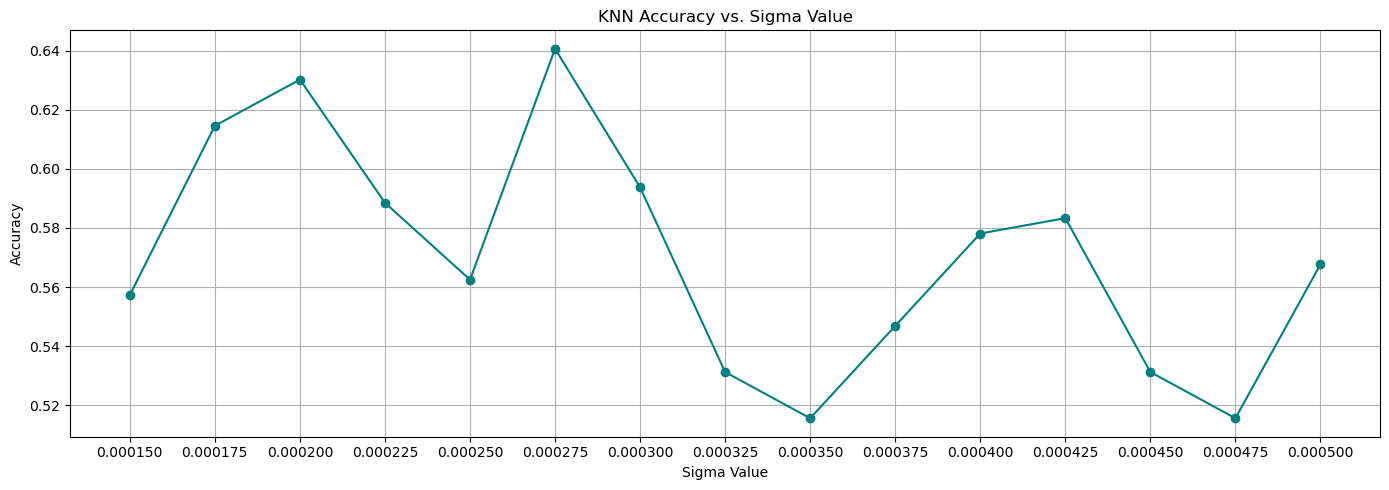

In [177]:
plt.figure(figsize=(14, 5))
plt.plot(sigma_list, accuracy, marker='o', linestyle='-', color='teal')
plt.title("KNN Accuracy vs. Sigma Value")
plt.xlabel("Sigma Value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(sigma_list)
plt.tight_layout()
plt.show()

In [154]:
accuracy

[0.5729166666666666,
 0.5520833333333334,
 0.5520833333333334,
 0.5625,
 0.5260416666666666,
 0.4635416666666667,
 0.5520833333333334,
 0.6197916666666666,
 0.609375,
 0.53125]

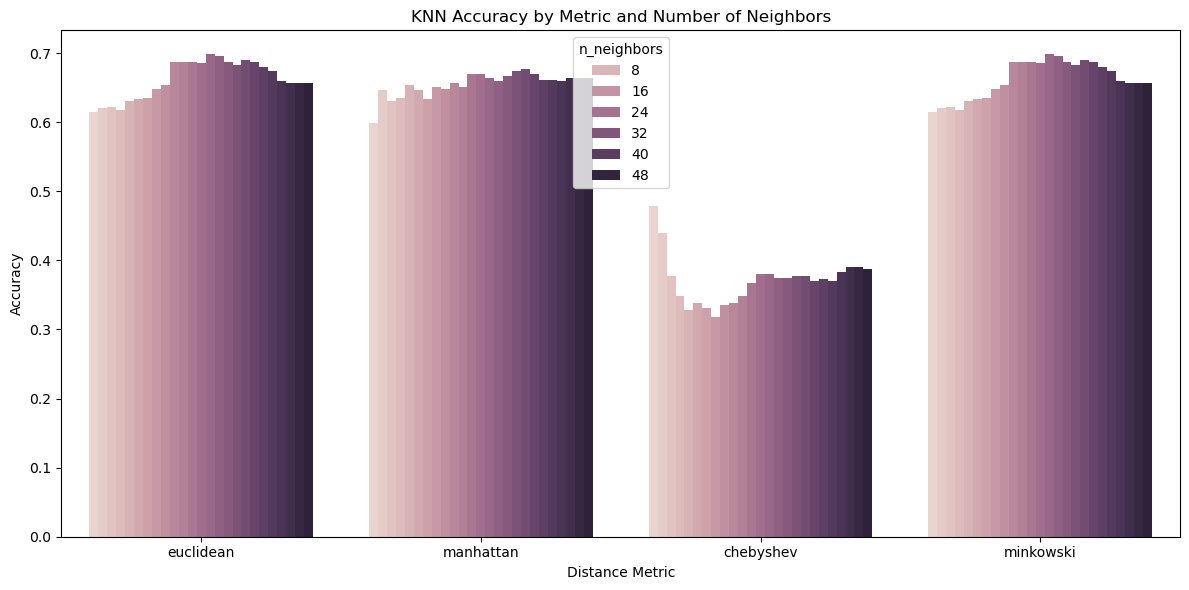

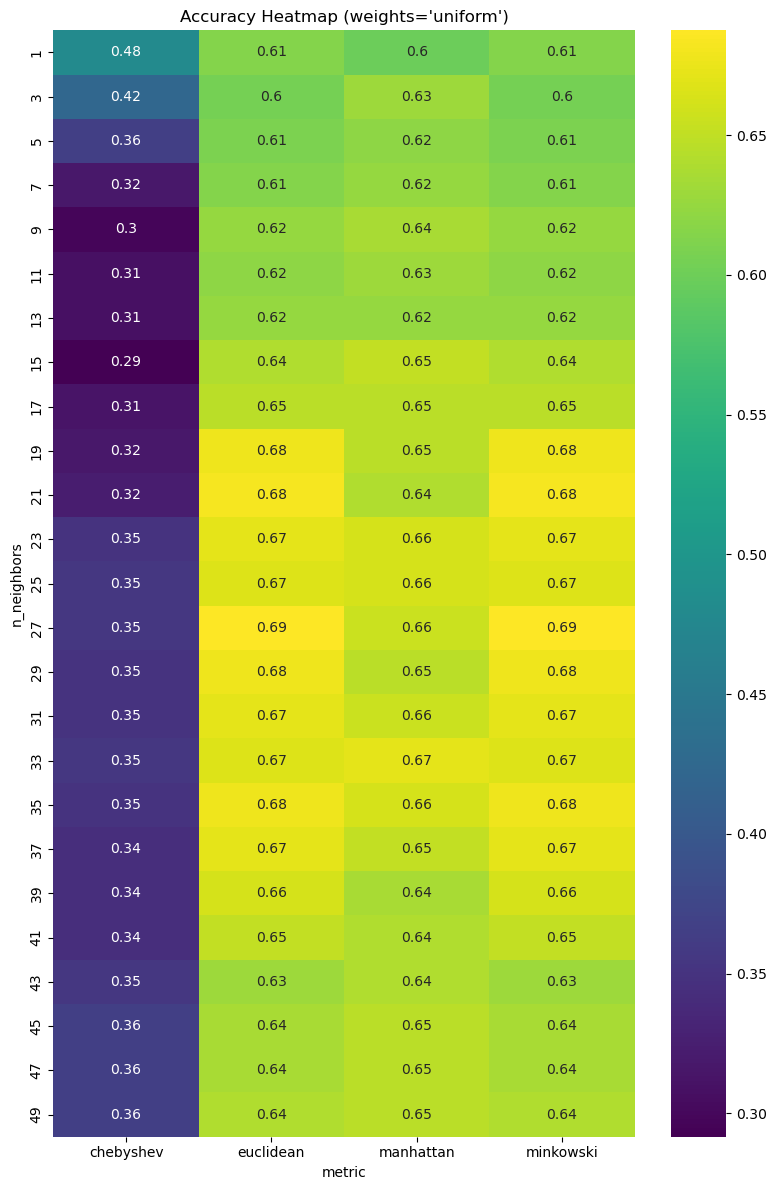

In [188]:
#knn feature testing for X_sigma3
n_neighbors=[]
n=1
for i in range(25):
    n_neighbors.append(n)
    n+=2

weights=['uniform', 'distance']
metrics=['euclidean', 'manhattan', 'chebyshev', 'minkowski']
results=[]
for neighbor in n_neighbors:
    for weight in weights:
        for metric in metrics:
            X_knn_sigma12= KNeighborsClassifier(n_neighbors=neighbor, metric=metric, weights= weight)
            X_knn_sigma12.fit(X_train_sigma12, y_train_sigma12)
            y_pred_sigma12 = X_knn_sigma12.predict(X_test_sigma12)
            acc = accuracy_score(y_test_sigma12, y_pred_sigma12)
            results.append((neighbor, weight, metric, acc))

df = pd.DataFrame(results, columns=['n_neighbors', 'weights', 'metric', 'accuracy'])

plt.figure(figsize=(12, 6))
sn.barplot(data=df, x='metric', y='accuracy', hue='n_neighbors', errorbar=None)
plt.title("KNN Accuracy by Metric and Number of Neighbors")
plt.ylabel("Accuracy")
plt.xlabel("Distance Metric")
plt.legend(title="n_neighbors")
plt.tight_layout()
plt.show()

#Heatmap for fixed weights
pivot = df[df['weights'] == 'uniform'].pivot(index='n_neighbors', columns='metric', values='accuracy')

plt.figure(figsize=(8, 12))
sn.heatmap(pivot, annot=True, cmap='viridis')
plt.title("Accuracy Heatmap (weights='uniform')")
plt.ylabel("n_neighbors")
plt.xlabel("metric")
plt.tight_layout()
plt.show()

In [187]:
n = len(X_train_sigma0) + len(X_test_sigma0)
print(f"Total samples for sigma0: {n}")


Total samples for sigma0: 960


# CNN Model 1D:

**Preparing Data for the CNN:**

In [35]:
# Combine all gesture data into one array X
X = np.concatenate((click_data, pinch_data, swipe_data, wave_data), axis=0)

# Create corresponding labels
y_click = np.full(click_data.shape[0], 'click')
y_pinch = np.full(pinch_data.shape[0], 'pinch')
y_swipe = np.full(swipe_data.shape[0], 'swipe')
y_wave = np.full(wave_data.shape[0], 'wave')

y = np.concatenate((y_click, y_pinch, y_swipe, y_wave), axis=0)

# One-Hot Encode the labels (y)
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse_output=False)
y_oh = onehot_encoder.fit_transform(y_int.reshape(-1, 1))

# Reshape X for Conv1D layer ()
X_cnn = np.expand_dims(X, axis=2)

# Get input shape and number of classes for the model
input_shape = (X_cnn.shape[1], 1)
num_classes = y_oh.shape[1]

# Create Train/Test Split
X_train_cnn, X_test_cnn, y_train_oh, y_test_oh = train_test_split(
    X_cnn, y_oh, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train_cnn.shape}")
print(f"y_train shape: {y_train_oh.shape}")
print(f"Input shape for CNN: {input_shape}")
print(f"Number of classes: {num_classes}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (6, 40) + inhomogeneous part.

# CNN Model 2D: